# TP4 : Équations différentielles partielles
## PHY-3500: Physique numérique (H2021) - 2 avril 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.constants as const
from matplotlib import animation, rc
from IPython.display import HTML
import sys
import timeit
np.set_printoptions(threshold=sys.maxsize)

### Commentaires
1. Si vous changez des facon d'agir de librairies, essayez au moins d'indiquer (rapidement) pourquoi c'est fait.

### L'équation de Schrödinger et la méthode de Crank-Nicolson

On doit faire un programme qui effectuera la résolution de l'équation de Schrödinger selon la méthode Crank-Nicolson pour un électron. On doit donc calculer $\psi(t+h)$ à partir de la condition initiale de l'électron et on utilise $h=10^{-18} \mathrm{~s}$ et $N=1000$ avec $ a=L / N $. 

#### Question 1

La première étape consiste à calculer la quantité $\mathbf{v}=\mathbf{B} \psi$. On ne doit pas recourir à une librairie externe mais plutôt exploiter le fait que $\mathrm{B}$ est tridiagonale. En effet, on sait que l'expression simple de $v_{i}$ est possible et est donnée par

$$
v_i = b_1 \psi_i + b_2 (\psi_{i+1} + \psi_{i-1}).
$$

Cette expression a été trouvée dans le livre Computational Physics de Mark Newman.


On sait que les fonctions d'onde doivent être normalisées pour respecter la physique du problème. On définit donc d'abord une fonction qui normalise une fonction d'onde quelconque. Cette fonction sera utilisée plus tard dans le rapport.

In [2]:
def normalize_psi(psi, x):
    """
    Fonction qui normalise une fonction d'onde.
    
    psi: Fonction d'onde. (np.ndarray)
    x: Vecteur position de la fonction d'onde. (np.ndarray)
    
    normalized_wave_function: Fonction d'onde normalisée. (np.ndarray)
    """
    int_psi_square = integrate.simps(np.abs(psi)** 2, x)
    normalized_wave_function = psi/np.sqrt(int_psi_square)
    
    return normalized_wave_function

### Commentaire
1. Il peut être utile dans un docstring lorsque vous indiqué que c'est un ndarray, de quel dimensionalité l'array doit être (ou si n'importe quelle dimension est acceptée)

On définit d'abord les constantes importantes du problème.

In [3]:
hbar = const.hbar
m = const.electron_mass # [kg]
L = 10**-8  # [m]
h = 10**-18 # [s]
N = 1000    # [-]
a = L/N     # [m]

sigma = 1*10**-10   # [m]
k = 5*10**10        # [m^-1]

On doit aussi définir les coefficients des matrices symétriques et tridiagonales A et B de l'équation de Crank-Nicolson.

In [4]:
a1 = 1 + h*1j*hbar / (2*m*a**2)
a2 = -h*(1j*hbar / (4*m*a**2))
b1 = 1 - h*(1j*hbar / (2*m*a**2))
b2 = h*(1j*hbar / (4*m*a**2))

On définit ensuite une fonction qui retourne la fonction d'onde initiale de l'électron à $t=0$ secondes.

In [5]:
def initial_wave_function(x, L, sigma, k):
    """
    Fonction d'onde initiale de l'électron.

    Parameters
    ----------
    x: La position de l'électron en m. (np.ndarray)
    L: La longueur totale de la boîte. (float)
    sigma: L'écart type de la gaussienne qui modélise la position de l'électron. (float)
    k: Le vecteur d'onde de l'électron. (float)
    
    Returns
    -------
    wave_function: L'équation d'onde au temps 0 seconde. (np.ndarray)
    """
    x0 = L/2 # [m]
    return np.exp(-((x-x0)**2)/(2*sigma**2))*np.exp(1j*k*x)


On définit les conditions initiales et on obtient la fonction d'onde initiale de l'électron sous forme d'un vecteur. On sait que $\psi=0 \text { aux parois à } x=0 \text { et } x=L$.

In [6]:
x = np.linspace(0, L, N+1)
psi_0 = initial_wave_function(x=x, L=L, sigma=sigma, k=k)
psi_0[[0, N]] = 0

psi_0 = normalize_psi(psi_0, x)


On définit une fonction qui permet d'obtenir le vecteur $v$ à partir d'une fonction d'onde $\psi$ et des valeurs sur les diagonales d'une matrice $B$ tridiagonale.

In [7]:
def get_vector_v(psi, b1, b2):
    """
    Fonction qui retourne la valeur du vecteur v selon la fonction d'onde et les valeurs sur la diagonale
    de la matrice B.

    Parameters
    ----------
    psi: Fonction d'onde de l'électron. (np.ndarray)
    b1: Valeur sur la diagonale centrale de la matrice B. (float)
    b2: Valeur sur les diagonales au-dessus et en-dessous de la diagonale centrale. (float)
    
    Returns
    -------
    v: Vecteur v. (np.ndarray)
    """
    N = len(psi) - 1
    v = np.zeros(len(psi), complex)

    v[0] = b1*psi[0] + b2*psi[1]
    v[1:N] = b1*psi[1:N] + b2*(psi[2:N+1] + psi[0:N-1])
    v[N] = b1*psi[N] + b2*psi[N-1]

    return v

On peut ensuite trouver le vecteur $v$ dans notre cas.

In [8]:
v = get_vector_v(psi=psi_0, b1=b1, b2=b2)

On trace les vecteurs $\psi$ et $v$ pour les visualiser.

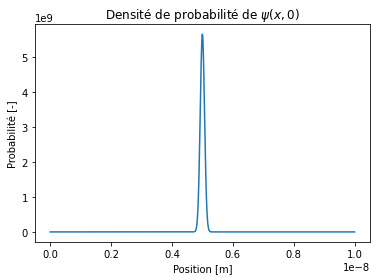

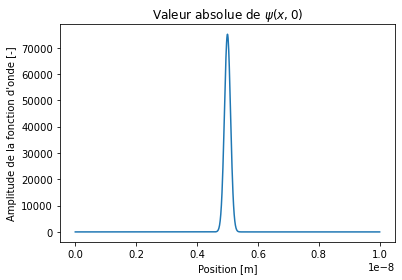

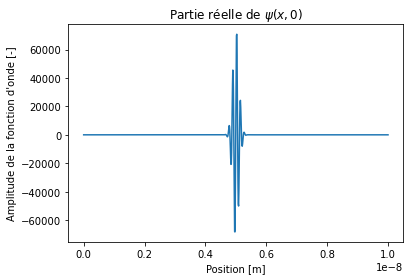

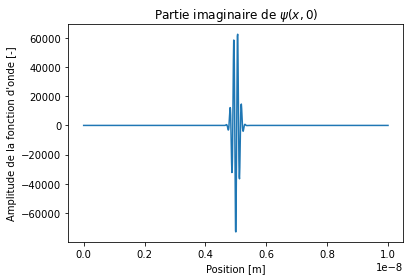

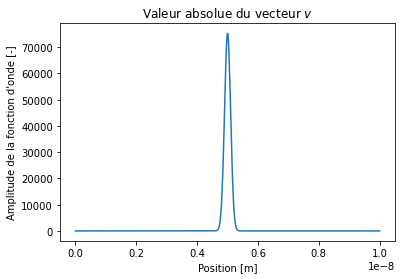

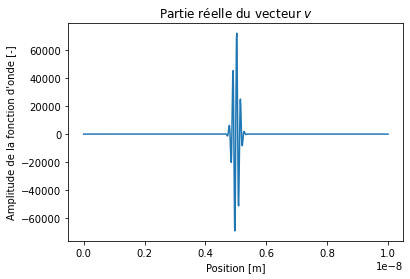

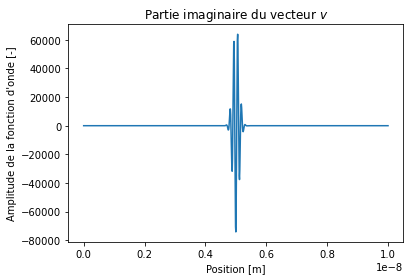

In [9]:
x_array = np.linspace(0, L, N + 1)

plt.plot(x_array, np.abs(psi_0)**2)
plt.title('Densité de probabilité de $\psi (x,0)$')
plt.xlabel("Position [m]")
plt.ylabel("Probabilité [-]")
plt.show()

plt.plot(x_array, np.abs(psi_0))
plt.title('Valeur absolue de $\psi (x,0)$')
plt.xlabel("Position [m]")
plt.ylabel("Amplitude de la fonction d'onde [-]")
plt.show()

plt.plot(x_array, np.real(psi_0))
plt.title('Partie réelle de $\psi (x,0)$')
plt.xlabel("Position [m]")
plt.ylabel("Amplitude de la fonction d'onde [-]")
plt.show()

plt.plot(x_array, np.imag(psi_0))
plt.title('Partie imaginaire de $\psi (x,0)$')
plt.xlabel("Position [m]")
plt.ylabel("Amplitude de la fonction d'onde [-]")
plt.show()

plt.plot(x_array, np.abs(v))
plt.title('Valeur absolue du vecteur $v$')
plt.xlabel("Position [m]")
plt.ylabel("Amplitude de la fonction d'onde [-]")
plt.show()

plt.plot(x_array, np.real(v))
plt.title('Partie réelle du vecteur $v$')
plt.xlabel("Position [m]")
plt.ylabel("Amplitude de la fonction d'onde [-]")
plt.show()

plt.plot(x_array, np.imag(v))
plt.title('Partie imaginaire du vecteur $v$')
plt.xlabel("Position [m]")
plt.ylabel("Amplitude de la fonction d'onde [-]")
plt.show()


### Commentaires
1. Joli travail, bonne demo graphique. Alternativement les graphiques aurait pu etre fait dans 2 figures avec 4 subplots afin de regrouper un peu mieu visuellement (voire ci-dessous) Le code suivant aurait aussi pu etre reduit avec une utilisation judicieuse de list et loops.

### Note
2.0/2.0

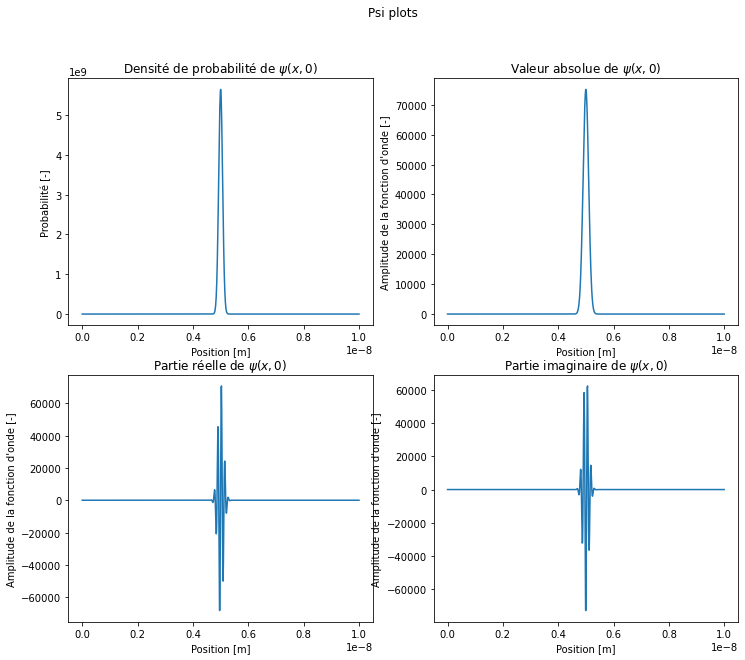

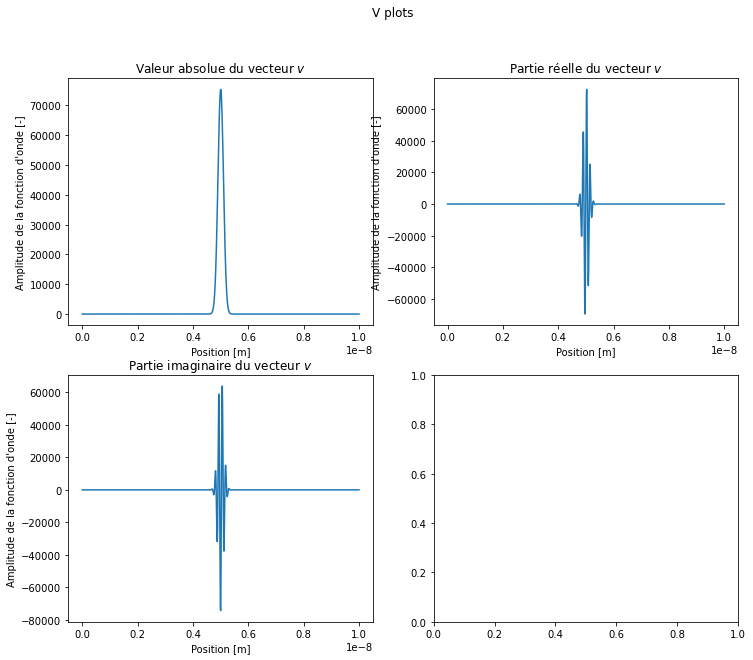

In [10]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

fig.suptitle('Psi plots')
ax1.plot(x_array, np.abs(psi_0)**2)
ax1.title.set_text('Densité de probabilité de $\psi (x,0)$')
ax1.set_xlabel("Position [m]")
ax1.set_ylabel("Probabilité [-]")

ax2.plot(x_array, np.abs(psi_0))
ax2.title.set_text('Valeur absolue de $\psi (x,0)$')
ax2.set_xlabel("Position [m]")
ax2.set_ylabel("Amplitude de la fonction d'onde [-]")

ax3.plot(x_array, np.real(psi_0))
ax3.title.set_text('Partie réelle de $\psi (x,0)$')
ax3.set_xlabel("Position [m]")
ax3.set_ylabel("Amplitude de la fonction d'onde [-]")

ax4.plot(x_array, np.imag(psi_0))
ax4.title.set_text('Partie imaginaire de $\psi (x,0)$')
ax4.set_xlabel("Position [m]")
ax4.set_ylabel("Amplitude de la fonction d'onde [-]")

plt.show()
plt.close()

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

fig.suptitle('V plots')

ax1.plot(x_array, np.abs(v))
ax1.title.set_text('Valeur absolue du vecteur $v$')
ax1.set_xlabel("Position [m]")
ax1.set_ylabel("Amplitude de la fonction d'onde [-]")

ax2.plot(x_array, np.real(v))
ax2.title.set_text('Partie réelle du vecteur $v$')
ax2.set_xlabel("Position [m]")
ax2.set_ylabel("Amplitude de la fonction d'onde [-]")

ax3.plot(x_array, np.imag(v))
ax3.title.set_text('Partie imaginaire du vecteur $v$')
ax3.set_xlabel("Position [m]")
ax3.set_ylabel("Amplitude de la fonction d'onde [-]")

plt.show()
plt.close()

#### Question 2

On doit résoudre le système $\mathbf{A x}=\mathbf{v}$ en recourant à un algorithme spécifiquement conçu pour les matrices tridiagonales. La fonction suivante est issue de l'algorithme de Thomas conçu pour les matrices tridiagonales (annexe E Newman). La fonction *solve_banded_equation* retourne un single array de même longueur que le vecteur $v$ du système Ax = v. 
A est un array qui contient la matrice et les variables upper et lower qui spécifient le nombre d'éléments, au dessus et
sous la diagonale, de la matrice qui ne sont pas des 0. La fonction consiste à utiliser une matrice A avec 
comme éléments de ses rangées les diagonales de la matrice tridiagonale et à effectuer une élimation gausienne.

In [11]:
def solve_banded_equation(A_array, v_array, upper, lower):
    """
    Calcul de la  solution du système d'équation Ax = v à l'aide de l'algorithme de Thomas.

    Parameters
    ----------
    A_array: Matrice avec comme éléments de ses rangées les diagonales de la matrice tridiagonale A. (np.ndarray)
    v_array: Array des valeurs du vecteur v. (np.ndarray)
    upper: Nombre d'éléments au dessus de la diagonale. (int)
    lower: Nombre d'éléments sous la diagonale. (int)
   
    Returns
    -------
    v: Le vecteur solution, soit le vecteur x. (np.ndarray)
    """
    # La taille du système est donnée par la longueur du vecteur v 
    A = np.copy(A_array)
    v = np.copy(v_array)
    N = len(v)

    # Élimination gaussienne
    for i in range(N):

        # Facteur de normalisation
        div = A[upper, i]

        # Mise à jour initial du vecteur v
        v[i] /= div
        for k in range(1, lower+1):
            if i+k < N:
                v[i+k] -= A[upper+k, i]*v[i]

        # Normalisation de la rangée pivot de A et la soustraire des rangées inférieures
        for m in range(upper):
            j = i + upper - m
            if j<N:
                A[m,j] /= div
                for k in range(1, lower+1):
                    A[m+k, j] -= A[upper+k, i]*A[m,j]

    # Substitution arrière
    for m in range(N-2, -1, -1):
        for i in range(upper):
            j = m + upper - i
            if j<N:
                v[m] -= A[i,j]*v[j]
    
    return v

On définit d'abord la matrice A telle qu'elle est. Pour ce faire, un fonction créant des matrices tridiagonales est réalisée.

In [12]:
def create_tridiag(main_value,off_value,size):
    """
    Crée une matrice tridiagonale symétrique.

    Parameters
    ----------
    main_value: Valeurs sur la diagonale principale. (float)
    off_value: Valeurs sur les diagonales secondaires. (float)
    size: Taille de la matrice finale voulue. (int)

    Returns
    -------
    mat: matrice tridiagonale symétrique. (np.ndarray)
    """
    main_diag = np.ones(size+1) * main_value
    off_diag = np.ones(size) * off_value
    mat = np.diag(main_diag,0) + np.diag(off_diag,-1) + np.diag(off_diag,1)
    return mat

A_tri = create_tridiag(a1,a2,N)


Dans notre cas, la fonction *solve_banded_equation* a plutôt besoin de la matrice $A$ sous une forme différente, soit la matrice A avec ses diagonales originales mises sur des rangées.

In [13]:
A_diag_as_rows = np.empty((3, N+1),complex)

A_diag_as_rows[0,:] = a2
A_diag_as_rows[1,:] = a1
A_diag_as_rows[2:,] = a2


On peut ensuite résoudre le système d'équation $A x = v$ qui est, en d'autres termes, $\mathbf{A} \psi(t+h)=\mathbf{B} \psi(t)$. On obtient donc $\psi(t+h)$ et on visualise cette fonction d'onde sur un graphique.

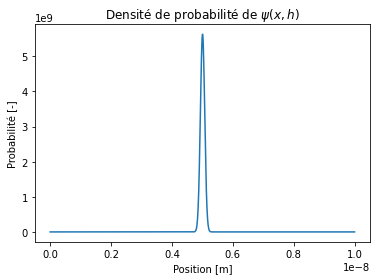

In [14]:
psi_1 = solve_banded_equation(A_diag_as_rows, v, 1, 1)

plt.plot(x_array, np.abs(psi_1)**2)
plt.title('Densité de probabilité de $\psi (x, h)$')
plt.xlabel("Position [m]")
plt.ylabel("Probabilité [-]")
plt.show()


### Commentaires
1. Si vous copiez-coller une fonction (solve_banded_equation), il faut au minimum donner une référence à l'auteur (-0.1)
2. L'axe de probabilité ne fait pas beaucoup de sens ici. Il faudrait renormalisée votre fonction tel que recomandé dans le TP4. (-0.1)

### Note
1.9/2.0

#### Question 3

Dans cette section, on résout l'équation pour un certain intervalle de temps et une animation est réalisant illustrant ainsi le comportement de la fonction d'onde graphiquement. Nécessite l'installation de ffmpeg afin de compiler l'animation. Il faut aussi s'assurer de rouler ce bloc de code à chaque fois que le notebook est fermé et ouvert. La compilation prend quelques minutes.

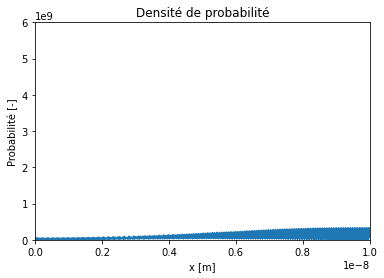

In [15]:
rc('animation', html='html5')
psi = psi_0

solution = [psi]
for i in range(5000):
    v = get_vector_v(psi, b1=b1, b2=b2)
    
    psi = solve_banded_equation(A_array=A_diag_as_rows, v_array=v, upper=1, lower=1)
    psi = normalize_psi(psi, x)
    solution.append(psi)

fig = plt.figure()
ax = plt.axes()
ax.set_xlim((0,L))
ax.set_ylim((0, 6e9))
ax.set_title("Densité de probabilité")
ax.set_xlabel('x [m]')
ax.set_ylabel("Probabilité [-]")
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,
            

def animate_func(i):
    x = np.linspace(0, L, N + 1)
    y = np.abs(solution[i]) ** 2
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate_func, init_func=init,
                               frames=5000, interval=10, blit=True)


anim

#### Commentaires

1. Les codes sont bien commentés et écrit en général, bravo !

2. Pour cette partie-là question 3, il manque de commentaires dans le code et d'utiliser plusieurs cellules.

3. Belle vidéo !

4. Le vidéo démontre le comportement attendu de la fonction d'onde en fonction du temps.

5. L'échelle utilisée n'est pas idéale, on ne peut pas bien voir ce que se passe quand l'onde est plus petite.

6. Ce serait aussi intéressant de tracer la partie réelle de $\psi$.

#### Note

2.0/2.0

#### Question 4

Dans cette section, l'algorithme réalisé à la question 2 est refait, mais cette fois en n'utilisant pas le fait que les matrices utilisées sont trigonales et donc en utilisant numpy.linalg. De plus, le gain en temps de résolution est évalué. Tout d'abord, les matrices A et B sont réalisées.

In [16]:
A_tri = create_tridiag(a1,a2,N)

B_tri = create_tridiag(b1,b2,N)

Par la suite, la fonction de création du vecteur v est réécrite pour faire utilisation du calcul matriciel.

In [17]:
def get_vector_v_linalg(psi,B):
    """
    Calcul le  vecteur v.

    Parameters
    ----------
    psi: Array des valeurs de Psi. (np.ndarray)
    B: Matrice tridiagonale symétrique des valeurs de B. (np.ndarray)

    Returns
    -------
    v: vecteur v. (np.ndarray)
    """
    v = np.matmul(psi,B)
    return v

Ensuite, la fonction de résolution est changée pour faire utilisation de np.linalg. Pour ce faire, on utilise seulement, linalg.solve pour résoudre le système.

In [18]:
def solve_banded_equation_linalg(A_array, v_array):
    """
    Calcul la  solution du système d'équation Ax = v.

    Parameters
    ----------
    v_array: Array des valeurs du vecteur v. (np.ndarray)
    A_array: Matrice tridiagonale symétrique des valeurs de a. (np.ndarray)

    Returns
    -------
    psi: vecteur psi. (np.ndarray)
    """
    
    psi = np.linalg.solve(A_array,v_array)
    
    return psi

Finalement, les solutions obtenues par le module linalg de numpy et celles obtenues précédements sont comparées.

Le temps de calcul pour la méthode faisant usage de la trigonalité est de 0.008900699999912831s et est de 
 53.82954399999994s pour la méthode faisant usage du module linalg.


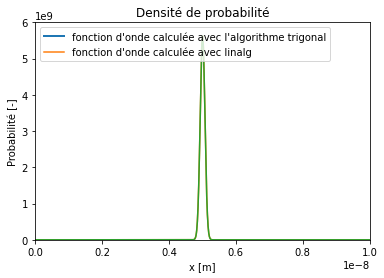

In [19]:
time_trigonal_start = timeit.default_timer()
v_trigonal = get_vector_v(psi=psi_0, b1=b1, b2=b2)
psi_trigonal = solve_banded_equation(A_array=A_diag_as_rows, v_array=v_trigonal, upper=1, lower=1)
time_trigonal_total  = timeit.default_timer()-time_trigonal_start

time_linalg_start = timeit.default_timer()
v_linalg = get_vector_v_linalg(psi_0 , B_tri)
psi_linalg = solve_banded_equation_linalg(A_array=A_tri, v_array=v_linalg)
time_linalg_total  = timeit.default_timer()-time_linalg_start

print(f"Le temps de calcul pour la méthode faisant usage de la trigonalité est de {time_trigonal_total}s et est de \n"
     f" {time_linalg_total}s pour la méthode faisant usage du module linalg.")

fig = plt.figure()
ax = plt.axes()
ax.set_xlim((0,L))
ax.set_ylim(( 0,6e9))
ax.set_title("Densité de probabilité")
ax.set_xlabel('x [m]')
ax.set_ylabel("Probabilité [-]")
x = np.linspace(0, L, N + 1)
line, = ax.plot([], [], lw=2)

plt.plot(x, abs(psi_linalg)**2)
plt.plot(x, abs(psi_trigonal)**2)
plt.legend(["fonction d'onde calculée avec l'algorithme trigonal", "fonction d'onde calculée avec linalg"], loc = 2)

plt.show()

On peut donc voir que la méthode faisant usage de la méthode trigonale est plus rapide que celle faisant usage de numpy.linalg. Toutefois, cela est normal puisque le nombre d'opération réalisés est très différent. En effet, numpy.linalg traite des matrices qui sont de tailles 1001x1001 tandis que la méthode trigonale ne réalise des opérations que sur les diagonales de ces matrices ce qui réduit grandement le nombre d'opérations faites. Par contre, comme le montre le graphique réalisé plus haut, on voit que les deux méthodes donnent un résultat pratiquement identique.

#### Commentaires

1. Code bien écrit et bien commenté.

2. Bonne analyse du temps de calcule.

3. Bonne analyse des résultats avec les deux différentes méthodes.

#### Note

2.0/2.0

#### Question 5

Tout d'abord, on peut voir que l'onde se déplace initialement vers la droite, ce qui est attendu puisque le vecteur d'onde $\kappa$ est positif ($5*10^{10}~m^{-1}$). Dans le cas présent, celui-ci n'est qu'une constante puisque la propagation de l'onde ne se fait qu'en 1D, soit sur l'axe x. De plus, il est possible de voir qu'il y a de la dispersion de la fonction d'onde plus le temps avance. En effet, l'onde gagne en largeur et diminue en amplitude plus le temps avance dans la simulation, et ce, très rapidement si l'on condière le lapse de temps qui est simulé dans l'animation. La manière la plus simple d'observer l'effet de la dispersion sur l'onde est de mettre une valeur nulle au vecteur d'onde $\kappa$ afin d'observer la dispersion de l'onde seulement sans propagation et réflexions lorsque celle-ci se retrouve dans les « coins » dans la boîte unidimensionelle. Il est aussi possible de modifier la valeur de la variable $\sigma$ qui vient directement affecter la largeur de la fonction d'onde initiale et donc comment elle se disperse aussi. Finalement, tel que dit dans l'énoncé précédent, il est possible d'observer les réflexions que subit la fonction d'onde lorsque celle-ci se déplace vers un « coin » de la boîte. Dans les moments où il y a réflexion, on observe qu'il est alors beaucoup plus probable de trouver l'électron près de l'interface ce qui est aussi attendu.

#### Commentaires

1. Pourquoi il y a telle dispersion de la fonction d'onde ? Ce quoi la physique derrière tel processus ? (-0.1)

    1.1. Qu'est-ce que se passe avec les mesures lorsque que l'onde est dispersé sur toute la boîte, qu'est-ce qui arrive avec une mesure de position?  (-0.1)

    1.2. C'est quoi la différence entre mesurer la position d'électron en $t=0$ et quand l'onde est dispersé ? 
    
2. Les réflexions fut bien discutée ainsi que les coins de la boîte et l'effet sur la fonction d'onde.

#### Note

0.8/1.0

### Qualité de code
1. Il n'y a pas un seul commentaire (non traduis) dans votre code pour la logique de votre code
2. Bonne utilisation de docstrings
3. Bonne descriptions des unitées de variables

### Note Finale
Questions (90%), Qualité de code (10%)

Questions: 8.7/9.0    
Qualité de code: 8.5/10

Total: 96%